## Imports and datafraem


In [1]:
# DBscan from scratch
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons

# Load the data
old_df = pd.read_csv('new_dataset.csv')

# Print the first 5 rows of the data    
old_df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,0.547619,1,1.0,0.715820,Sales,0.000000,0.250000,Life Sciences,0.333333,0.0,...,0.00,0.00,0.0,0.000,0.0,0.00,0.15,0.222222,0.000000,0.344828
1,0.814978,0,0.5,0.185735,Research & Development,0.275862,0.157895,Life Sciences,0.727273,1.0,...,0.92,1.00,0.5,0.025,0.5,0.75,0.25,0.388889,0.066667,0.482759
2,0.613136,1,1.0,0.915934,Research & Development,0.068966,0.380435,Other,1.000000,1.0,...,0.60,0.50,0.0,0.025,0.5,0.75,0.00,0.000000,0.000000,0.000000
3,0.545855,0,0.5,0.928610,Research & Development,0.103448,0.793478,Life Sciences,1.000000,0.0,...,0.44,0.75,0.0,0.025,0.5,0.75,0.20,0.388889,0.200000,0.000000
4,0.444950,0,1.0,0.394188,Research & Development,0.068966,0.173913,Medical,0.181818,1.0,...,0.48,1.00,0.5,0.025,0.5,0.75,0.05,0.111111,0.133333,0.137931


In [2]:
df = old_df.copy()
columns = ['Department', 'EducationField', 'JobRole', 'MaritalStatus', 'OverTime']
#target based encoding, each category of the column will bear the mean
for column in columns:
        if column == 'Department':
                df[column] = df.groupby(column)['JobSatisfaction'].transform('mean')
        elif column == 'EducationField':
                df[column] = df.groupby(column)['HourlyRate'].transform('mean')
        elif column == 'JobRole':
                df[column] = df.groupby(column)['HourlyRate'].transform('mean')
        elif column == 'MaritalStatus':
                df[column] = df.groupby(column)['WorkLifeBalance'].transform('mean')
        elif column == 'OverTime':
                df[column] = df.groupby(column)['YearsSinceLastPromotion'].transform('mean')

df.head()


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,0.547619,1,1.0,0.715820,0.673292,0.000000,0.250000,0.667702,0.333333,0.0,...,0.00,0.00,0.0,0.000,0.0,0.00,0.15,0.222222,0.000000,0.344828
1,0.814978,0,0.5,0.185735,0.666719,0.275862,0.157895,0.667702,0.727273,1.0,...,0.92,1.00,0.5,0.025,0.5,0.75,0.25,0.388889,0.066667,0.482759
2,0.613136,1,1.0,0.915934,0.666719,0.068966,0.380435,0.623913,1.000000,1.0,...,0.60,0.50,0.0,0.025,0.5,0.75,0.00,0.000000,0.000000,0.000000
3,0.545855,0,0.5,0.928610,0.666719,0.103448,0.793478,0.667702,1.000000,0.0,...,0.44,0.75,0.0,0.025,0.5,0.75,0.20,0.388889,0.200000,0.000000
4,0.444950,0,1.0,0.394188,0.666719,0.068966,0.173913,0.653232,0.181818,1.0,...,0.48,1.00,0.5,0.025,0.5,0.75,0.05,0.111111,0.133333,0.137931


In [3]:
class DBSCAN: 
    def __init__(self, eps, min_pts, data):
        self.eps = eps
        self.min_pts = min_pts
        self.data = data
        self.clusters = []
        self.noise = []
        self.core_pts = []
        self.visited = []
        self.clustered = []
        self.cluster_num = 0
        self.clustered_pts = []
        
    def _distance(self, p1, p2):
        result = 0
        for i in range(len(p1)):
            if(type(p1[i]) == str or type(p2[i]) == str):
                if(p1[i] != p2[i]):
                    result += 1
            else : result += (p1[i] - p2[i]) ** 2
        return math.sqrt(result)
        #return math.sqrt(sum([(a - b) ** 2 for a, b in zip(p1, p2)]))
    
    def _region_query(self, point):
        neighbors = []
        for i in range(len(self.data)):
            if self._distance(point, self.data[i]) < self.eps:
                neighbors.append(i)
        return neighbors
    
    def _expand_cluster(self, point, neighbors):
        self.clusters[self.cluster_num].append(point)
        self.clustered.append(point)
        self.visited.append(point)
        for i in neighbors:
            if i not in self.visited:
                self.visited.append(i)
                new_neighbors = self._region_query(self.data[i])
                if len(new_neighbors) >= self.min_pts:
                    neighbors += new_neighbors
            if i not in self.clustered:
                self.clusters[self.cluster_num].append(i)
                self.clustered.append(i)
                
    def fit(self):
        for i in range(len(self.data)):
            if i not in self.visited:
                self.visited.append(i)
                neighbors = self._region_query(self.data[i])
                if len(neighbors) < self.min_pts:
                    self.noise.append(i)
                else:
                    self.clusters.append([])
                    self._expand_cluster(i, neighbors)
                    self.cluster_num += 1
                    
    def get_clusters(self):
        return self.clusters
    
    def get_noise(self):
        return self.noise



In [4]:
Y = df['Attrition'].values
df = df.drop(['Attrition'], axis=1)
X = df.values

old_df = old_df.drop(['Attrition'], axis=1)
X_db = old_df.values

In [5]:
dbscan = DBSCAN(eps=1.2, min_pts=2, data=X_db)
dbscan.fit()
clusters = dbscan.get_clusters()
noise = dbscan.get_noise()

In [6]:
len(dbscan.get_clusters())

155

In [7]:
dbscan.get_clusters()

[[4, 405, 550, 10, 183, 781, 831, 1088, 843, 840, 1224, 868, 965, 1302],
 [5,
  556,
  1042,
  177,
  296,
  430,
  1180,
  1325,
  816,
  264,
  856,
  1018,
  1082,
  1083,
  1205,
  1343,
  1354,
  42],
 [8, 1002, 66, 822, 969, 1091, 136, 211, 85],
 [9, 266],
 [12, 345, 242, 67, 902, 1069, 166, 432, 519, 982, 120],
 [13, 373, 404, 797],
 [18, 417],
 [19, 369, 857, 912, 961, 1332, 514, 1339],
 [24,
  72,
  274,
  565,
  598,
  618,
  940,
  1152,
  81,
  498,
  998,
  1115,
  512,
  1170,
  1141,
  1217,
  1381,
  68,
  162,
  516,
  883,
  1089,
  272,
  722,
  1127,
  1092,
  1367],
 [27,
  403,
  520,
  768,
  1026,
  151,
  987,
  646,
  297,
  844,
  1257,
  158,
  576,
  638,
  1276,
  447,
  121,
  1355,
  241,
  1143],
 [28, 928, 465],
 [30, 146, 687],
 [32, 1108],
 [34, 69, 294, 1028, 1252, 474],
 [38, 122],
 [39, 583, 802, 376, 834, 1132, 1333, 137, 167, 771],
 [40, 740, 761],
 [44, 426, 1050, 930, 207],
 [49,
  113,
  1134,
  939,
  1017,
  1227,
  87,
  399,
  581,
  953,

In [8]:
len(dbscan.get_noise())

848

In [9]:
dbscan.get_noise()

[0,
 1,
 2,
 3,
 6,
 7,
 11,
 14,
 15,
 16,
 17,
 20,
 21,
 22,
 23,
 25,
 26,
 29,
 31,
 33,
 35,
 36,
 37,
 41,
 43,
 45,
 46,
 47,
 48,
 50,
 51,
 52,
 55,
 57,
 61,
 62,
 63,
 64,
 65,
 70,
 77,
 78,
 79,
 82,
 83,
 86,
 88,
 90,
 92,
 95,
 96,
 97,
 98,
 104,
 105,
 106,
 108,
 110,
 111,
 112,
 114,
 116,
 117,
 119,
 123,
 124,
 125,
 126,
 127,
 129,
 132,
 133,
 134,
 135,
 139,
 140,
 141,
 142,
 144,
 147,
 150,
 152,
 153,
 155,
 159,
 160,
 163,
 164,
 165,
 171,
 172,
 173,
 174,
 178,
 180,
 182,
 187,
 189,
 190,
 192,
 194,
 195,
 197,
 198,
 200,
 201,
 204,
 205,
 208,
 209,
 210,
 212,
 213,
 215,
 218,
 219,
 220,
 221,
 224,
 225,
 226,
 227,
 231,
 232,
 233,
 235,
 236,
 237,
 238,
 239,
 243,
 244,
 245,
 247,
 249,
 250,
 256,
 257,
 258,
 260,
 261,
 263,
 265,
 267,
 268,
 269,
 270,
 271,
 275,
 276,
 277,
 278,
 279,
 281,
 283,
 286,
 288,
 290,
 295,
 300,
 302,
 303,
 304,
 305,
 307,
 308,
 311,
 313,
 314,
 315,
 316,
 317,
 319,
 322,
 323,
 326,
 33

In [10]:
# # sklearn dbscan
# from sklearn.cluster import DBSCAN
# from sklearn.preprocessing import StandardScaler

# X = df.values
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# dbscan = DBSCAN(eps=0.5, min_samples=5)
# clusters = dbscan.fit_predict(X_scaled)

# clusters

In [11]:
class AGNES:
    def __init__(self, n_clusters=2, linkage='average'):
        self.n_clusters = n_clusters
        self.linkage = linkage
        self.labels_ = None
        self.cluster_centers_ = None
        self.n_leaves = None
        self.results = {}
        self.linkage_matrix = []
        self.merge_history = []

    def fit(self, X):
        #X = np.array([self.string_to_numerical(x) for x in X])
        
        self.n_leaves = X.shape[0]
        self.labels_ = np.arange(self.n_leaves)
        self.cluster_centers_ = X.copy()
        self.results[self.n_leaves] = [self.labels_.copy(), self.cluster_centers_.copy()]
        self.linkage_matrix = np.empty((0,4), dtype=float)
        self.merge_history = list(range(X.shape[0]))
        #print(self.merge_history)
        # while self.n_leaves >= self.n_clusters:
        #     self.merge()

        while self.n_leaves >= 1:
            self.merge()
            self.results[self.n_leaves] = [self.labels_.copy(), self.cluster_centers_.copy()]
        return self

    def merge(self):
        dist = self.distance(self.cluster_centers_)
        np.fill_diagonal(dist, np.inf)
        i, j = np.unravel_index(dist.argmin(), dist.shape)
        #i, j = np.unravel_index(self.masked_argmin(dist,0), dist.shape)
        self.cluster_centers_[i] = self._linkage(i, j)
        
        self.cluster_centers_ = np.delete(self.cluster_centers_, j, axis=0)
        self.labels_[self.labels_ == j] = i
        self.labels_[self.labels_ > j] -= 1
        self.n_leaves -= 1
        # we need to keep track of the clusters, problem is i and j are being lost
        self.linkage_matrix = np.vstack((self.linkage_matrix, [self.merge_history[i], self.merge_history[j], dist[i, j], self.n_leaves]))
        #print(i,j)
        self.merge_history[i] = max(self.merge_history)+1
        self.merge_history[j] = max(self.merge_history)+1
    
    def get_linkage_matrix(self):
        return self.linkage_matrix
    
    def string_to_numerical(self,arr):
        """Convert a string to a numerical value"""
        # Convert the string to a list of ASCII values
        new_arr = []
        for s in arr:
            #print(type(s))
            if (type(s) == str):
                ascii_values = [ord(c) for c in s]
                # Convert the list of ASCII values to a numpy array
                ascii_array = np.array(ascii_values)
                # Return the sum of the array
                new_arr.append(ascii_array.sum())
            else: new_arr.append(s)
        return np.array(new_arr)

    def distance(self, X):
        return np.sqrt(-2 * np.dot(X, X.T) + np.sum(X ** 2, axis=1) + np.sum(X ** 2, axis=1)[:, np.newaxis])


    def _distance(self, p1, p2):
        result = 0
        for i in range(len(p1)):
            if(type(p1[i]) == str or type(p2[i]) == str):
                if(p1[i] != p2[i]):
                    result += 1
            else : result += (p1[i] - p2[i]) ** 2
        return math.sqrt(result)

    def distance2(self, X):
        distances = []
        for i in range(len(X)):
            for j in range(len(X)):
                distances.append(self._distance(X[i], X[j]))
        return np.array(distances).reshape(len(X), len(X))
                
    

    def _linkage(self, i, j):
        if self.linkage == 'average':
            # linkage = []
            # for i in range (len(self.cluster_centers_[i])):
            #     if type(self.cluster_centers_[i][i]) == str:
            #         if self.cluster_centers_[i][i] != self.cluster_centers_[j][i]:
            #             linkage.append(0)
            #         else: linkage.append(1)
            #     else: linkage.append((self.cluster_centers_[i][i] + self.cluster_centers_[j][i]))
            # linkage = np.array(linkage)
            # return linkage / 2
            return (self.cluster_centers_[i] + self.cluster_centers_[j]) / 2
        elif self.linkage == 'single':
            return np.minimum(self.cluster_centers_[i], self.cluster_centers_[j])
        elif self.linkage == 'complete':
            return np.maximum(self.cluster_centers_[i], self.cluster_centers_[j])
        else:
            raise ValueError('Unknown linkage method: {}'.format(self.linkage))

    def predict(self, X):
        return self.labels_

    def fit_predict(self, X):
        self.fit(X)
        return self.predict(X)

    def get_results(self):
        return self.results

In [12]:
agnes = AGNES(n_clusters=2, linkage='average')
res = agnes.fit_predict(X)
res

C:\Users\YsPC\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in sqrt


array([0, 0, 0, ..., 0, 0, 0])

In [13]:
results = agnes.get_results()

In [14]:
results[3]

[array([0, 0, 0, ..., 0, 0, 0]),
 array([[0.77838967, 0.85919004, 0.51295722, 0.67064799, 0.6703432 ,
         0.54763638, 0.66082127, 0.62864387, 0.36791991, 0.70404669,
         0.49016219, 0.75280721, 0.65835494, 0.87274628, 0.68934107,
         0.95286928, 0.46568831, 0.27617696, 0.15714771, 0.64355006,
         0.46251775, 0.77067241, 0.87633833, 0.60383123, 0.58006585,
         0.78661959, 0.82663453, 0.79171342, 0.68562601],
        [0.84917179, 0.5       , 0.9713129 , 0.66671891, 0.03448276,
         0.79347826, 0.65323212, 0.21428571, 0.        , 0.29790887,
         0.47826087, 0.58695652, 0.66800854, 0.21428571, 0.69361702,
         0.11297226, 0.95544267, 0.33333333, 0.15753585, 0.8       ,
         0.75      , 0.        , 0.025     , 0.16666667, 0.5       ,
         0.325     , 0.66666667, 0.8       , 0.55172414],
        [0.96648262, 1.        , 0.09802407, 0.66671891, 0.79310345,
         0.79347826, 0.65323212, 1.        , 0.        , 0.93982076,
         0.73913043, 0.

In [15]:
for each in results[2][0]:
        print(each)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [16]:
def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy

def precision(y_true, y_pred):
    tp = np.sum(y_true * y_pred)
    fp = np.sum((1 - y_true) * y_pred)
    return tp / (tp + fp)

def sensitivity(y_true, y_pred):
    tp = np.sum(y_true * y_pred)
    fn = np.sum(y_true * (1 - y_pred))
    return tp / (tp + fn)

def specificity(y_true, y_pred):
    tn = np.sum((1 - y_true) * (1 - y_pred))
    fp = np.sum((1 - y_true) * y_pred)
    return tn / (tn + fp)

def f_score(y_true, y_pred):
    tp = np.sum(y_true * y_pred)
    fn = np.sum(y_true * (1 - y_pred))
    fp = np.sum((1 - y_true) * y_pred)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    return 2 * precision * recall / (precision + recall)

# confusion matrix containing true positives, false negatives, false positives and true negatives
def confusion_matrix(y_true, y_pred):
    tp = np.sum(y_true * y_pred)
    fn = np.sum(y_true * (1 - y_pred))
    fp = np.sum((1 - y_true) * y_pred)
    tn = np.sum((1 - y_true) * (1 - y_pred))
    return np.array([[tp, fn], [fp, tn]])

In [17]:
print(f"accuracy = {accuracy(Y, results[2][0])}")
print(f"precision = {precision(Y, results[2][0])}")
print(f"sensitivity = {sensitivity(Y, results[2][0])}")
print(f"specificity = {specificity(Y, results[2][0])}")
print(f"f_score = {f_score(Y, results[2][0])}")
print(f"confusion_matrix = \n{confusion_matrix(Y, results[2][0])}")

accuracy = 0.8380952380952381
precision = 0.0
sensitivity = 0.0
specificity = 0.9991889699918897
f_score = nan
confusion_matrix = 
[[   0  237]
 [   1 1232]]


C:\Users\YsPC\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


In [18]:
dbscan_res = {}
val = 0
for cluster in dbscan.get_clusters():
        for i in cluster:
                dbscan_res[i] = val
        val += 1

In [19]:
# order dict by key
dbscan_res = {k: dbscan_res[k] for k in sorted(dbscan_res)}
dbscan_res = list(dbscan_res.values())

In [20]:
len(dbscan_res)

622

In [21]:
len(Y)

1470

In [22]:
R = np.delete(Y, noise)

In [23]:
len(R)

622

In [24]:
dbscan_res = np.array(dbscan_res)

In [25]:
print(f"accuracy = {accuracy(R, dbscan_res)}")
print(f"precision = {precision(R, dbscan_res)}")
print(f"sensitivity = {sensitivity(R, dbscan_res)}")
print(f"specificity = {specificity(R, dbscan_res)}")
print(f"f_score = {f_score(R, dbscan_res)}")
print(f"confusion_matrix = \n{confusion_matrix(R, dbscan_res)}")


accuracy = 0.03054662379421222
precision = 0.13818789475174895
sensitivity = 57.4
specificity = -55.66294227188082
f_score = 0.27571202531645567
confusion_matrix = 
[[  4879  -4794]
 [ 30428 -29891]]


In [26]:
# sklearn agglomerative clustering 
from sklearn.cluster import AgglomerativeClustering
agg = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='average')
agg_res = agg.fit_predict(X)

In [27]:
for each in agg_res:
        print(each)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [28]:
print(f"accuracy = {accuracy(Y, agg_res)}")
print(f"precision = {precision(Y, agg_res)}")
print(f"sensitivity = {sensitivity(Y, agg_res)}")
print(f"specificity = {specificity(Y, agg_res)}")
print(f"f_score = {f_score(Y, agg_res)}")
print(f"confusion_matrix = \n{confusion_matrix(Y, agg_res)}")

accuracy = 0.8367346938775511
precision = 0.0
sensitivity = 0.0
specificity = 0.9975669099756691
f_score = nan
confusion_matrix = 
[[   0  237]
 [   3 1230]]


C:\Users\YsPC\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


### This part is yet to be tested:

In [29]:
def inter_cluster(X, labels):
    # calculate the mean of each cluster
    cluster_means = []
    for i in range(len(np.unique(labels))):
        cluster_means.append(np.mean(X[labels == i], axis=0))
    cluster_means = np.array(cluster_means)
    # calculate the mean of all data points
    all_mean = np.mean(X, axis=0)
    # calculate the inter cluster distance
    inter_cluster_dist = np.sum(np.square(cluster_means - all_mean), axis=1)
    return inter_cluster_dist

In [30]:
inter_cluster(X, results[2][0])

array([1.23444760e-06, 2.66388977e+00])

In [31]:
def intra_cluster(X, labels):
    # calculate the mean of each cluster
    cluster_means = []
    for i in range(len(np.unique(labels))):
        cluster_means.append(np.mean(X[labels == i], axis=0))
    cluster_means = np.array(cluster_means)
    # calculate the intra cluster distance
    intra_cluster_dist = []
    for i in range(len(np.unique(labels))):
        intra_cluster_dist.append(np.sum(np.square(X[labels == i] - cluster_means[i])))
    intra_cluster_dist = np.array(intra_cluster_dist)
    return intra_cluster_dist

In [32]:
intra_cluster(X, results[2][0])

array([2345.11834933,    0.        ])

In [33]:
# import dendrogram plotting
from scipy.cluster.hierarchy import dendrogram


In [34]:
#import linkage
from scipy.cluster.hierarchy import linkage

In [35]:
def draw_dendrogram(X, linkage_type= 'average'):
    # calculate the distance between each sample
    distance_matrix = linkage(X, linkage_type)
    # plot the dendrogram
    dendrogram(distance_matrix)
    plt.title("dendrogram for AGNES with linkage type " + linkage_type)
    plt.show()

In [36]:
(X.shape, results[2][0].shape)

((1470, 29), (1470,))

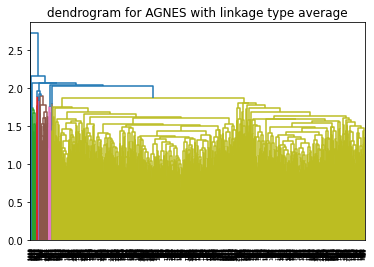

In [37]:
draw_dendrogram(X)

## Benchmarking

### For DBScan

In [38]:
#import sklearn metrics silouhette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

In [74]:
# for dbscan, we will select a few different hyperparameters and see how the results change throughout all combinations of hyperparameters
def gridsearch_dbscan(X, eps, min_samples):
    # create a dictionary to store the results
    results = {}
    # iterate through all combinations of hyperparameters
    for e in eps:
        for m in min_samples:
            # create a dbscan object
            dbscan = DBSCAN(eps=e, min_pts=m, data=X)
            # fit the model
            dbscan.fit()
            # get the labels
            dbscan_res = {}
            val = 0
            clusters = dbscan.get_clusters()
            noise = dbscan.get_noise()
            #clusters.append(noise)
            for cluster in clusters:
                    for i in cluster:
                            dbscan_res[i] = val
                    val += 1
            dbscan_res = {k: dbscan_res[k] for k in sorted(dbscan_res)}
            labels = list(dbscan_res.values())  
            # delete noise from X
            X = np.delete(X, noise, axis=0)
            try:
            # calculate the inter cluster distance
                inter_cluster_dist = inter_cluster(X, labels)
                # calculate the intra cluster distance
                intra_cluster_dist = intra_cluster(X, labels)
                # calculate the silhouette score
                silhouette_score_ = silhouette_score(X, labels)
                # calculate the davies bouldin score
                davies_bouldin_score_ = davies_bouldin_score(X, labels)
                # calculate the calinski harabasz score
                calinski_harabasz_score_ = calinski_harabasz_score(X, labels)
                # store the results in the dictionary
                results[(e, m)] = (inter_cluster_dist, intra_cluster_dist, silhouette_score, davies_bouldin_score, calinski_harabasz_score)
            except:
                pass
            #results[(e, m)] = (silhouette_score_, davies_bouldin_score_, calinski_harabasz_score_)
    return results

In [75]:
eps = [0.5, 0.7, 1, 1.2, 1.5, 1.7, 2]
min_samples = [2, 3, 4, 5, 6, 7, 8, 9, 10]

results_db = gridsearch_dbscan(X, eps, min_samples)
results_db

c:\Users\YsPC\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\Users\YsPC\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
c:\Users\YsPC\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\Users\YsPC\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


{(0.5,
  2): (array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan]]), array([0., 0., 0.]), <function sklearn.metrics.cluster._unsupervised.silhouette_score(X, labels, *, metric='euclidean', sample_size=None, random_state=None, **kwds)>, <function sklearn.metrics.cluster._unsupervised.davies_bouldin_score(X, labels)>, <function sklearn.metrics.cluster._unsupervised.calinski_harabasz_score(X, labels)>)}

### For AGNES

In [ ]:
#for AGNES, we will just try different linkages and see the results for 2 clusters
def benchmark_agnes(X):
        # create a dictionary to store the results
        results = {}
        # iterate through all linkages
        for linkage in ['single', 'complete', 'average']:
                # create an agnes object
                agnes = AGNES(n_clusters=2, linkage=linkage)
                # fit the model
                agnes.fit(X)
                # get the labels
                labels = agnes.get_results()[2][0]
                # calculate the inter cluster distance
                inter_cluster_dist = inter_cluster(X, labels)
                # calculate the intra cluster distance
                intra_cluster_dist = intra_cluster(X, labels)
                # calculate the silhouette score
                silhouette_score_ = silhouette_score(X, labels)
                # calculate the davies bouldin score
                davies_bouldin_score_ = davies_bouldin_score(X, labels)
                # calculate the calinski harabasz score
                calinski_harabasz_score_ = calinski_harabasz_score(X, labels)
                # store the results in the dictionary
                results[linkage] = (inter_cluster_dist, intra_cluster_dist, silhouette_score_, davies_bouldin_score_, calinski_harabasz_score_)
        return results

In [ ]:
results_agnes = benchmark_agnes(X)
results_agnes

C:\Users\YsPC\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in sqrt
C:\Users\YsPC\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in sqrt
C:\Users\YsPC\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in sqrt


{'single': (array([1.01621277e-05, 5.47490729e+00]),
  array([2.33556122e+03, 1.25810378e+00]),
  0.35639895699630963,
  0.8700933372522743,
  6.888092416109646),
 'complete': (array([4.12475054e-06, 2.22223410e+00]),
  array([2.34193517e+03, 1.39835704e+00]),
  0.1574989395430164,
  1.395253420204261,
  2.7880658784933794),
 'average': (array([1.23444760e-06, 2.66388977e+00]),
  array([2345.11834933,    0.        ]),
  0.1317443967477651,
  0.7634920932759633,
  1.6686800742768269)}